In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((400, 400)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, resnet50):
        super(ClassificationNet, self).__init__()
        
        # Get the feature extractor
        self.resnet50_fe = nn.Sequential(*list(resnet50.children())[:-1])

        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        #self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        x = self.resnet50_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(resnet50 = models.resnet50(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [30]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 23516228


# Train Model

In [15]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.1357084984244415
Val loss:  0.1284704783688421
train accuracy:  0.5193423597678917
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 2.516 minutes. Time expected till completion: 249.047 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


train loss:  0.12190879175234118
Val loss:  0.12316880174305128
train accuracy:  0.5957446808510638
Val accuracy:  0.5739130434782609
Current time: 4.410 minutes. Time expected till completion: 216.087 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.11516277356581255
Val loss:  0.11685902605886045
train accuracy:  0.6063829787234043
Val accuracy:  0.5652173913043478
Current time: 6.302 minutes. Time expected till completion: 203.755 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.10882602208357023
Val loss:  0.1132978802141936
train accuracy:  0.6189555125725339
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 8.218 minutes. Time expected till completion: 197.233 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.10911687600428177
Val loss:  0.1121537693168806
train accuracy:  0.6150870406189555
Val accuracy:  0.591304347826087
Current time: 10.120 minutes. Time expected till completion: 192.271 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.10900788911306651
Val loss:  0.10964474522549172
train accuracy:  0.6228239845261122
Val accuracy:  0.6086956521739131
Current time: 12.010 minutes. Time expected till completion: 188.152 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.10730776179228807
Val loss:  0.10937014559040899
train accuracy:  0.6334622823984526
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 13.929 minutes. Time expected till completion: 185.059 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.10522028616480025
Val loss:  0.10498919435169386
train accuracy:  0.6295938104448743
Val accuracy:  0.6086956521739131
Current time: 15.849 minutes. Time expected till completion: 182.261 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.10373544707404345
Val loss:  0.11238568140112835
train accuracy:  0.6334622823984526
Val accuracy:  0.6260869565217392
Current time: 17.776 minutes. Time expected till completion: 179.736 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.10416804942909477
Val loss:  0.10900090595950251
train accuracy:  0.6450676982591876
Val accuracy:  0.5478260869565217
Current time: 19.708 minutes. Time expected till completion: 177.372 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.10360114630924203
Val loss:  0.1067492796027142
train accuracy:  0.6441005802707931
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 21.643 minutes. Time expected till completion: 175.109 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.10360096530480818
Val loss:  0.10813950144726298
train accuracy:  0.6450676982591876
Val accuracy:  0.5739130434782609
Current time: 23.579 minutes. Time expected till completion: 172.911 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.10040275023338642
Val loss:  0.10953696914341139
train accuracy:  0.6615087040618955
Val accuracy:  0.6608695652173913
Best model at the moment with Val_acc 66.09, saving...
Current time: 25.530 minutes. Time expected till completion: 170.855 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.09797385026569293
Val loss:  0.10683281577151754
train accuracy:  0.6731141199226306
Val accuracy:  0.6173913043478261
Current time: 27.471 minutes. Time expected till completion: 168.750 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.09829257097188923
Val loss:  0.1081146434597347
train accuracy:  0.6692456479690522
Val accuracy:  0.5826086956521739
Current time: 29.392 minutes. Time expected till completion: 166.556 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


train loss:  0.09956405863771126
Val loss:  0.10996559365935947
train accuracy:  0.6586073500967118
Val accuracy:  0.5739130434782609
Current time: 31.297 minutes. Time expected till completion: 164.312 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


train loss:  0.09560029704404753
Val loss:  0.11282918660537056
train accuracy:  0.690522243713733
Val accuracy:  0.6260869565217392
Current time: 33.201 minutes. Time expected till completion: 162.100 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


train loss:  0.09541473729352194
Val loss:  0.10837248511936354
train accuracy:  0.6740812379110251
Val accuracy:  0.6260869565217392
Current time: 35.093 minutes. Time expected till completion: 159.866 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.09217959881635883
Val loss:  0.10760041760361713
train accuracy:  0.6963249516441006
Val accuracy:  0.6
Current time: 36.983 minutes. Time expected till completion: 157.663 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


train loss:  0.09644440721497084
Val loss:  0.11109779632609823
train accuracy:  0.6769825918762089
Val accuracy:  0.6608695652173913
Current time: 38.871 minutes. Time expected till completion: 155.483 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.09444696258760743
Val loss:  0.10748532699502032
train accuracy:  0.6760154738878144
Val accuracy:  0.6521739130434783
Current time: 40.761 minutes. Time expected till completion: 153.340 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


train loss:  0.0945833164557267
Val loss:  0.10891954354617907
train accuracy:  0.6789168278529981
Val accuracy:  0.591304347826087
Current time: 42.650 minutes. Time expected till completion: 151.214 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.09155645555811187
Val loss:  0.11098372521607772
train accuracy:  0.6847195357833655
Val accuracy:  0.6260869565217392
Current time: 44.541 minutes. Time expected till completion: 149.116 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.08994824358584572
Val loss:  0.11149809775145157
train accuracy:  0.7166344294003868
Val accuracy:  0.6086956521739131
Current time: 46.429 minutes. Time expected till completion: 147.027 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.08860869636503363
Val loss:  0.10920961862025054
train accuracy:  0.7001934235976789
Val accuracy:  0.6260869565217392
Current time: 48.321 minutes. Time expected till completion: 144.962 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


train loss:  0.08768955636877616
Val loss:  0.10971883198489314
train accuracy:  0.706963249516441
Val accuracy:  0.6347826086956522
Current time: 50.210 minutes. Time expected till completion: 142.906 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.08685863773181775
Val loss:  0.11257337228111598
train accuracy:  0.7088974854932302
Val accuracy:  0.6
Current time: 52.101 minutes. Time expected till completion: 140.865 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.0844014710395433
Val loss:  0.11260860536409462
train accuracy:  0.7127659574468085
Val accuracy:  0.6173913043478261
Current time: 53.991 minutes. Time expected till completion: 138.835 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.08317939115677396
Val loss:  0.11744469248730204
train accuracy:  0.7427466150870407
Val accuracy:  0.6260869565217392
Current time: 55.881 minutes. Time expected till completion: 136.812 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.08119918143726179
Val loss:  0.11188683872637542
train accuracy:  0.7369439071566731
Val accuracy:  0.6347826086956522
Current time: 57.771 minutes. Time expected till completion: 134.798 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


train loss:  0.08075598768558447
Val loss:  0.11467637860256692
train accuracy:  0.7311411992263056
Val accuracy:  0.6260869565217392
Current time: 59.661 minutes. Time expected till completion: 132.793 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.08448937048188031
Val loss:  0.11524536609649658
train accuracy:  0.7108317214700194
Val accuracy:  0.6
Current time: 61.550 minutes. Time expected till completion: 130.795 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


train loss:  0.07772813993911448
Val loss:  0.11476795284644417
train accuracy:  0.746615087040619
Val accuracy:  0.6347826086956522
Current time: 63.441 minutes. Time expected till completion: 128.804 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


train loss:  0.07790868467069456
Val loss:  0.11356424987316131
train accuracy:  0.7388781431334622
Val accuracy:  0.6
Current time: 65.329 minutes. Time expected till completion: 126.814 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.07523715174693896
Val loss:  0.12216177219929902
train accuracy:  0.7678916827852998
Val accuracy:  0.6086956521739131
Current time: 67.218 minutes. Time expected till completion: 124.834 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.07699921639272277
Val loss:  0.10986613190692404
train accuracy:  0.7495164410058027
Val accuracy:  0.6608695652173913
Current time: 69.108 minutes. Time expected till completion: 122.858 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.07755428997933057
Val loss:  0.10685642698536749
train accuracy:  0.7495164410058027
Val accuracy:  0.6782608695652174
Best model at the moment with Val_acc 67.83, saving...
Current time: 71.002 minutes. Time expected till completion: 120.895 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.06879875958830521
Val loss:  0.1243051290512085
train accuracy:  0.7746615087040619
Val accuracy:  0.6434782608695652
Current time: 72.894 minutes. Time expected till completion: 118.932 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


train loss:  0.06772169354056481
Val loss:  0.13572938519975414
train accuracy:  0.7727272727272727
Val accuracy:  0.6173913043478261
Current time: 74.785 minutes. Time expected till completion: 116.971 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


train loss:  0.07042462815399096
Val loss:  0.12336490076521169
train accuracy:  0.781431334622824
Val accuracy:  0.6347826086956522
Current time: 76.674 minutes. Time expected till completion: 115.011 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.06555559945867416
Val loss:  0.1383904112421948
train accuracy:  0.7949709864603481
Val accuracy:  0.5217391304347826
Current time: 78.565 minutes. Time expected till completion: 113.057 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.06600285520348374
Val loss:  0.118899281906045
train accuracy:  0.7843326885880078
Val accuracy:  0.6608695652173913
Current time: 80.479 minutes. Time expected till completion: 111.137 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


train loss:  0.06402144898125466
Val loss:  0.12939681559801103
train accuracy:  0.809477756286267
Val accuracy:  0.6347826086956522
Current time: 82.449 minutes. Time expected till completion: 109.293 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.06576296129413453
Val loss:  0.12071984228880508
train accuracy:  0.7920696324951644
Val accuracy:  0.6
Current time: 84.419 minutes. Time expected till completion: 107.443 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.06363493617717716
Val loss:  0.12980662273324053
train accuracy:  0.8017408123791102
Val accuracy:  0.6347826086956522
Current time: 86.363 minutes. Time expected till completion: 105.555 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.05947718805339858
Val loss:  0.13422840574513312
train accuracy:  0.8220502901353965
Val accuracy:  0.5826086956521739
Current time: 88.332 minutes. Time expected till completion: 103.694 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.058867897197056554
Val loss:  0.1092995910540871
train accuracy:  0.8123791102514507
Val accuracy:  0.6782608695652174
Current time: 90.281 minutes. Time expected till completion: 101.806 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.05718014699837456
Val loss:  0.163521356848271
train accuracy:  0.8239845261121856
Val accuracy:  0.6521739130434783
Current time: 92.251 minutes. Time expected till completion: 99.938 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.057885820366716016
Val loss:  0.12821438701256463
train accuracy:  0.8123791102514507
Val accuracy:  0.591304347826087
Current time: 94.204 minutes. Time expected till completion: 98.049 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.05429875613613562
Val loss:  0.13981280645922475
train accuracy:  0.8336557059961315
Val accuracy:  0.6347826086956522
Current time: 96.145 minutes. Time expected till completion: 96.145 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.05725547543418823
Val loss:  0.12926764475262684
train accuracy:  0.8230174081237911
Val accuracy:  0.6347826086956522
Current time: 98.090 minutes. Time expected till completion: 94.243 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.04912633204569669
Val loss:  0.12717629398988642
train accuracy:  0.8481624758220503
Val accuracy:  0.6347826086956522
Current time: 100.035 minutes. Time expected till completion: 92.340 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.053174771166747035
Val loss:  0.1201610249021779
train accuracy:  0.839458413926499
Val accuracy:  0.6260869565217392
Current time: 101.981 minutes. Time expected till completion: 90.436 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.0499388255625675
Val loss:  0.14121904606404512
train accuracy:  0.8491295938104448
Val accuracy:  0.6608695652173913
Current time: 103.927 minutes. Time expected till completion: 88.530 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.04260172227278669
Val loss:  0.13078692879365839
train accuracy:  0.8684719535783365
Val accuracy:  0.6173913043478261
Current time: 105.873 minutes. Time expected till completion: 86.624 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.047676014355464875
Val loss:  0.125549374455991
train accuracy:  0.8626692456479691
Val accuracy:  0.6434782608695652
Current time: 107.816 minutes. Time expected till completion: 84.713 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.04341518415617297
Val loss:  0.1668066822964212
train accuracy:  0.8665377176015474
Val accuracy:  0.6
Current time: 109.761 minutes. Time expected till completion: 82.802 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  0.043388649104325175
Val loss:  0.1387435285941414
train accuracy:  0.8800773694390716
Val accuracy:  0.6434782608695652
Current time: 111.739 minutes. Time expected till completion: 80.915 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.04044169124857139
Val loss:  0.15762050877446715
train accuracy:  0.8820116054158608
Val accuracy:  0.6086956521739131
Current time: 113.748 minutes. Time expected till completion: 79.046 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


train loss:  0.04518606167149728
Val loss:  0.1483601627142533
train accuracy:  0.8597678916827853
Val accuracy:  0.6434782608695652
Current time: 115.767 minutes. Time expected till completion: 77.178 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.04382549637002687
Val loss:  0.13872094931809797
train accuracy:  0.8665377176015474
Val accuracy:  0.5739130434782609
Current time: 117.797 minutes. Time expected till completion: 75.313 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.043832025348390785
Val loss:  0.15081642788389454
train accuracy:  0.874274661508704
Val accuracy:  0.6521739130434783
Current time: 119.820 minutes. Time expected till completion: 73.438 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.03544704786482009
Val loss:  0.14697961327822312
train accuracy:  0.8936170212765957
Val accuracy:  0.6
Current time: 121.847 minutes. Time expected till completion: 71.561 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.03564459290463528
Val loss:  0.1323668308880018
train accuracy:  0.8887814313346228
Val accuracy:  0.6086956521739131
Current time: 123.824 minutes. Time expected till completion: 69.651 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


train loss:  0.03810702422831921
Val loss:  0.13494114791569503
train accuracy:  0.9003868471953579
Val accuracy:  0.5652173913043478
Current time: 125.810 minutes. Time expected till completion: 67.744 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.035156702287711304
Val loss:  0.12290173069290493
train accuracy:  0.8926499032882012
Val accuracy:  0.6695652173913044
Current time: 127.794 minutes. Time expected till completion: 65.834 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.03795383260288137
Val loss:  0.1443029611007027
train accuracy:  0.8984526112185687
Val accuracy:  0.591304347826087
Current time: 129.777 minutes. Time expected till completion: 63.920 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.035892504301621095
Val loss:  0.14465430184550906
train accuracy:  0.8955512572533849
Val accuracy:  0.6173913043478261
Current time: 131.786 minutes. Time expected till completion: 62.017 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.03210297621952323
Val loss:  0.13771614846975908
train accuracy:  0.9158607350096711
Val accuracy:  0.6521739130434783
Current time: 133.792 minutes. Time expected till completion: 60.110 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.03121048242314872
Val loss:  0.1478663277366887
train accuracy:  0.9245647969052224
Val accuracy:  0.6608695652173913
Current time: 135.786 minutes. Time expected till completion: 58.194 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.030007146862722805
Val loss:  0.1423208659109862
train accuracy:  0.9158607350096711
Val accuracy:  0.6521739130434783
Current time: 137.745 minutes. Time expected till completion: 56.262 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.030539017410253534
Val loss:  0.1386860403029815
train accuracy:  0.9235976789168279
Val accuracy:  0.6608695652173913
Current time: 139.743 minutes. Time expected till completion: 54.345 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.027964284710182558
Val loss:  0.14352119694585386
train accuracy:  0.9168278529980658
Val accuracy:  0.6260869565217392
Current time: 141.693 minutes. Time expected till completion: 52.407 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.029216874776339625
Val loss:  0.1486509807407856
train accuracy:  0.9245647969052224
Val accuracy:  0.6173913043478261
Current time: 143.655 minutes. Time expected till completion: 50.473 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.02879280640024915
Val loss:  0.17697313350179922
train accuracy:  0.9264990328820116
Val accuracy:  0.591304347826087
Current time: 145.629 minutes. Time expected till completion: 48.543 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.029987588567151266
Val loss:  0.17564970773199332
train accuracy:  0.9197292069632496
Val accuracy:  0.6347826086956522
Current time: 147.614 minutes. Time expected till completion: 46.615 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.0242293298954227
Val loss:  0.16300077308779176
train accuracy:  0.9361702127659575
Val accuracy:  0.6347826086956522
Current time: 149.593 minutes. Time expected till completion: 44.684 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.02791325396153809
Val loss:  0.16108250579108363
train accuracy:  0.9284332688588007
Val accuracy:  0.5826086956521739
Current time: 151.572 minutes. Time expected till completion: 42.751 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.024305074821573968
Val loss:  0.16018733252649722
train accuracy:  0.9274661508704062
Val accuracy:  0.6173913043478261
Current time: 153.547 minutes. Time expected till completion: 40.816 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.022619141320692558
Val loss:  0.18461192289124365
train accuracy:  0.9381044487427466
Val accuracy:  0.6173913043478261
Current time: 155.534 minutes. Time expected till completion: 38.884 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.024757272659348795
Val loss:  0.16531131137972294
train accuracy:  0.9284332688588007
Val accuracy:  0.6173913043478261
Current time: 157.504 minutes. Time expected till completion: 36.945 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.018081409523418492
Val loss:  0.19891635905141417
train accuracy:  0.9477756286266924
Val accuracy:  0.6173913043478261
Current time: 159.488 minutes. Time expected till completion: 35.010 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.020890817056973852
Val loss:  0.15834996933522433
train accuracy:  0.9487427466150871
Val accuracy:  0.5826086956521739
Current time: 161.479 minutes. Time expected till completion: 33.074 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.023288482879387572
Val loss:  0.17722146977549014
train accuracy:  0.937137330754352
Val accuracy:  0.5217391304347826
Current time: 163.484 minutes. Time expected till completion: 31.140 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.020059503379369757
Val loss:  0.17110985983972965
train accuracy:  0.9487427466150871
Val accuracy:  0.5739130434782609
Current time: 165.463 minutes. Time expected till completion: 29.199 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


train loss:  0.019413534650035074
Val loss:  0.15958372231410897
train accuracy:  0.9535783365570599
Val accuracy:  0.6608695652173913
Current time: 167.465 minutes. Time expected till completion: 27.262 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.019369941148942974
Val loss:  0.14537587982157002
train accuracy:  0.9429400386847195
Val accuracy:  0.6173913043478261
Current time: 169.453 minutes. Time expected till completion: 25.321 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.019069890325935826
Val loss:  0.17369033175966014
train accuracy:  0.9468085106382979
Val accuracy:  0.6347826086956522
Current time: 171.451 minutes. Time expected till completion: 23.380 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.015101205386451988
Val loss:  0.17995468896368275
train accuracy:  0.9632495164410058
Val accuracy:  0.6173913043478261
Current time: 173.432 minutes. Time expected till completion: 21.435 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.018033805394696515
Val loss:  0.21051670675692352
train accuracy:  0.9642166344294004
Val accuracy:  0.6260869565217392
Current time: 175.445 minutes. Time expected till completion: 19.494 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.019698228339828566
Val loss:  0.19401048888330874
train accuracy:  0.9564796905222437
Val accuracy:  0.5739130434782609
Current time: 177.437 minutes. Time expected till completion: 17.549 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.022667717666867798
Val loss:  0.19308587830999624
train accuracy:  0.9448742746615088
Val accuracy:  0.6
Current time: 179.401 minutes. Time expected till completion: 15.600 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


train loss:  0.017531961577762517
Val loss:  0.19237160280994747
train accuracy:  0.9555125725338491
Val accuracy:  0.5652173913043478
Current time: 181.395 minutes. Time expected till completion: 13.653 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.016850217237863223
Val loss:  0.20233540262864982
train accuracy:  0.9642166344294004
Val accuracy:  0.6173913043478261
Current time: 183.365 minutes. Time expected till completion: 11.704 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


train loss:  0.015215515419822799
Val loss:  0.1922806478064993
train accuracy:  0.9680851063829787
Val accuracy:  0.5826086956521739
Current time: 185.363 minutes. Time expected till completion: 9.756 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.015916471392082004
Val loss:  0.1841060265250828
train accuracy:  0.9622823984526112
Val accuracy:  0.5826086956521739
Current time: 187.348 minutes. Time expected till completion: 7.806 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.01458331477077141
Val loss:  0.17199537741101306
train accuracy:  0.9632495164410058
Val accuracy:  0.6173913043478261
Current time: 189.338 minutes. Time expected till completion: 5.856 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.01658312591626822
Val loss:  0.18812430449154066
train accuracy:  0.9632495164410058
Val accuracy:  0.5826086956521739
Current time: 191.313 minutes. Time expected till completion: 3.904 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.016523206815919775
Val loss:  0.16716636432253795
train accuracy:  0.9574468085106383
Val accuracy:  0.6434782608695652
Current time: 193.288 minutes. Time expected till completion: 1.952 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.013422804818861546
Val loss:  0.17519395791965983
train accuracy:  0.9729206963249516
Val accuracy:  0.6347826086956522
Saving model 2 checkpoint


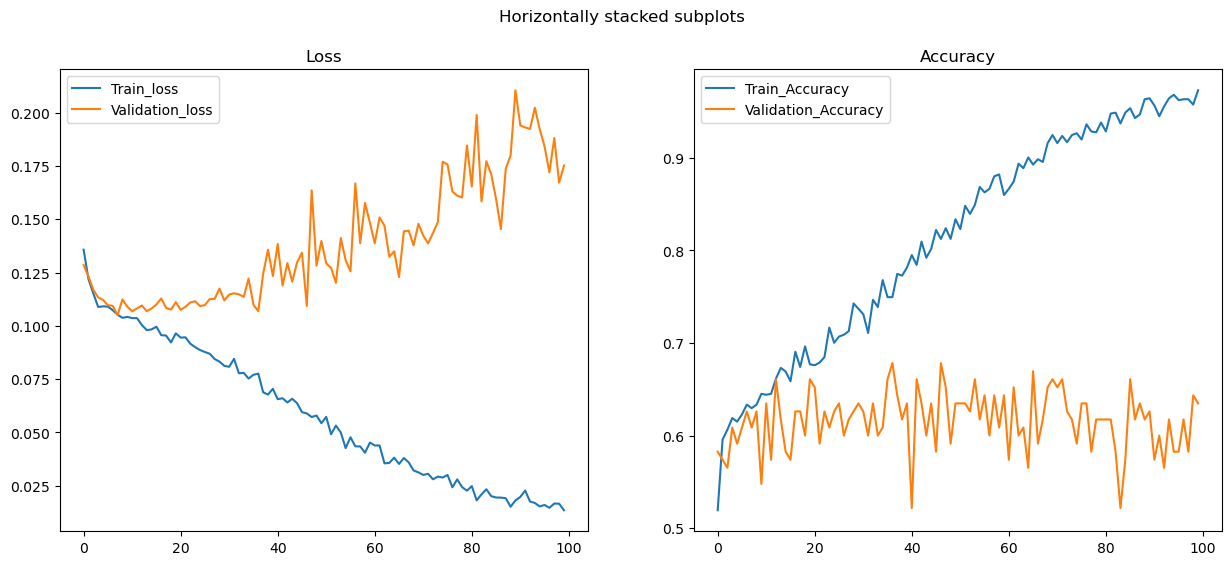

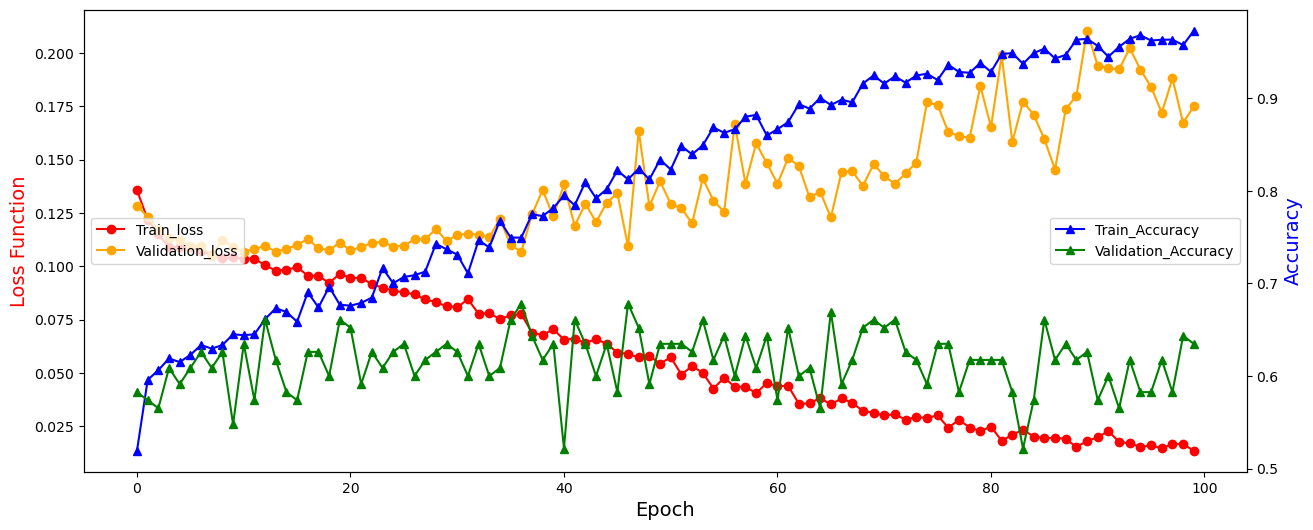

Current time: 195.859 minutes. Time expected till completion: 0.000 minutes
Finished training in: 195.871 minutes


In [16]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [17]:
best_model_val_acc

0.6782608695652174

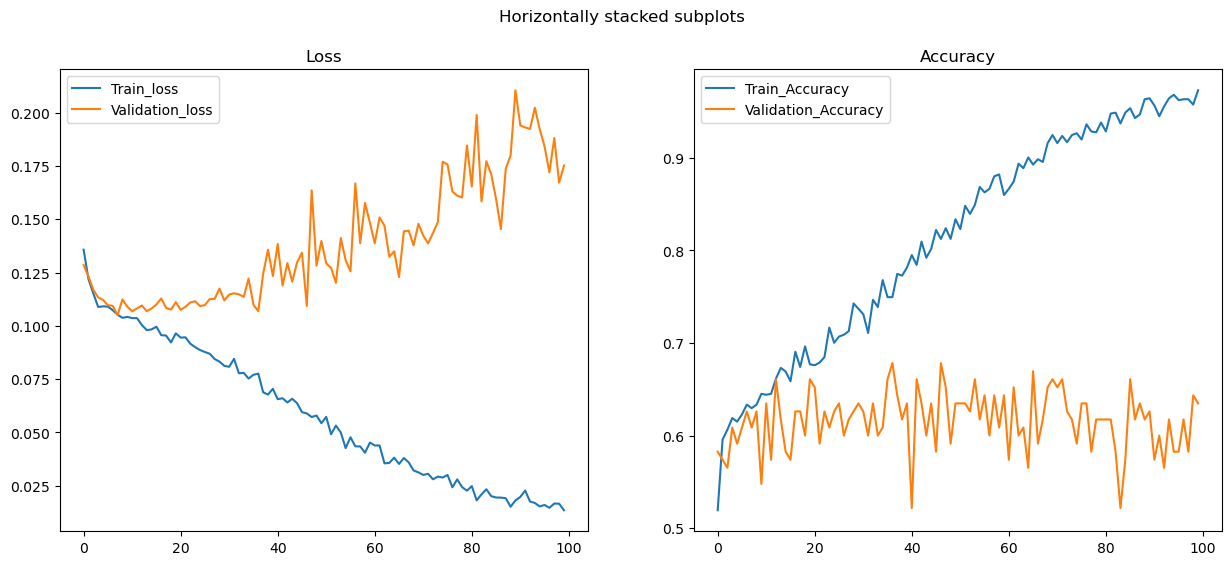

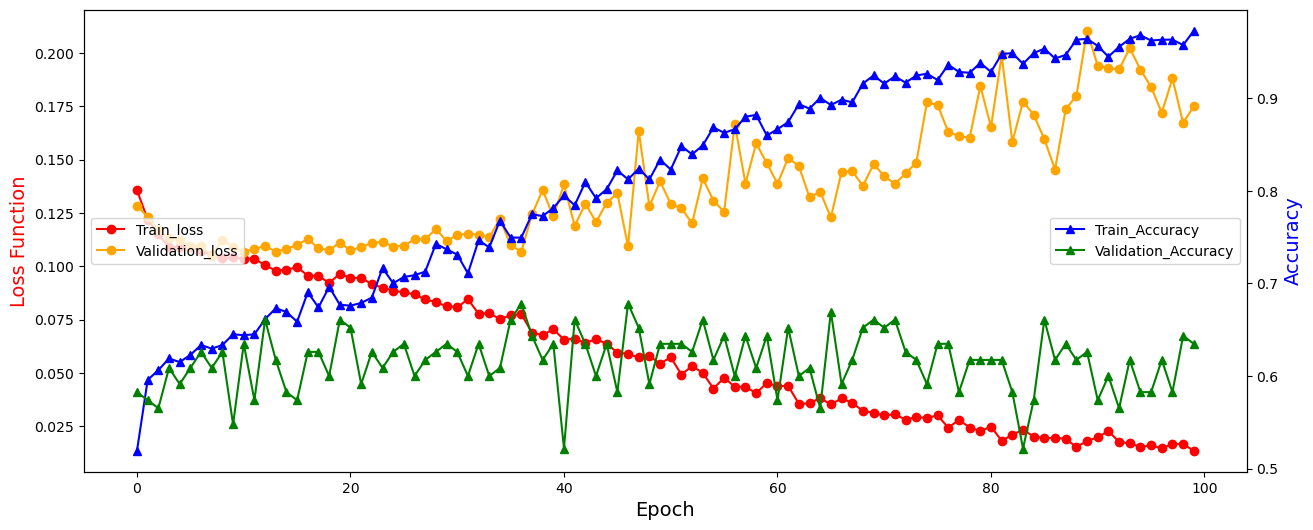

In [18]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [19]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [20]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Evaluate Last Model

In [21]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [22]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.39it/s]


Accuracy of the network on the 1034 Train instances: 99.22630560928434%


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

Accuracy of the network on the 115 Validation instances: 63.47826086956522%


## Test Predictions Last Model

In [23]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [24]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:23<00:00, 16.36it/s]


(array([0, 1, 2, 3]), array([152, 163,  61,   4], dtype=int64))

In [25]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_ResNet_prediction.csv")

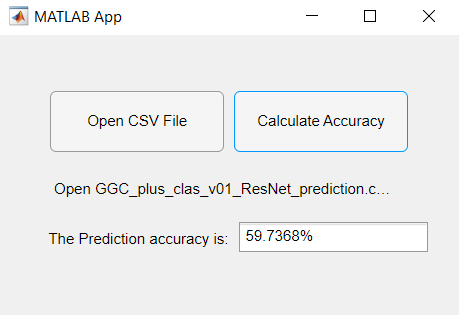

# Load Best Model

In [26]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Evaluate Best Model

In [27]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.40it/s]


Accuracy of the network on the 1034 Train instances: 82.7852998065764%


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

Accuracy of the network on the 115 Validation instances: 67.82608695652173%


## Test Predictions Best Model

In [28]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:17<00:00, 21.65it/s]


(array([0, 1, 2]), array([144, 180,  56], dtype=int64))

In [29]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_ResNet_best_prediction.csv")

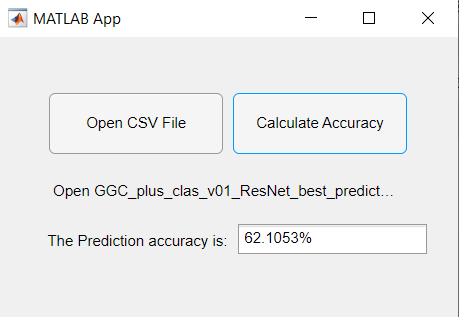